In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import Data

In [5]:
data = pd.read_excel('Data_Train--Delivery.xlsx',usecols = [0,1,2,3,4,5,6,7])

### EDA & Preprocessing

In [6]:
data.head()

,Restaurant,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12,4,30
1,ID_2882,"Ice Cream, Desserts",100,50,3.5,11,4,30
2,ID_1595,"Italian, Street Food, Fast Food",150,50,3.6,99,30,65
3,ID_5929,"Mughlai, North Indian, Chinese",250,99,3.7,176,95,30
4,ID_6123,"Cafe, Beverages",200,99,3.2,521,235,65


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7772 entries, 0 to 7771
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant     7772 non-null   object 
 1   Cuisines       7772 non-null   object 
 2   Average_Cost   7772 non-null   int64  
 3   Minimum_Order  7772 non-null   int64  
 4   Rating         7772 non-null   float64
 5   Votes          7772 non-null   int64  
 6   Reviews        7772 non-null   int64  
 7   Delivery_Time  7772 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 485.9+ KB


In [8]:
#Label encoding categorical variables
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data['Restaurant_Code'] = lb_make.fit_transform(data['Restaurant'])

#Check that encoding is correct 
#data.loc[data.duplicated(subset=['Restaurant_Code'])].sort_values(by=['Restaurant_Code'])

# creates X & Y
x_e = data.drop(columns = ['Delivery_Time','Restaurant','Cuisines'])
y_e = data.Delivery_Time

x_e.shape

(7772, 6)

In [9]:
#Binary encoding
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Restaurant_Code'])

x_b = encoder.fit_transform(x_e)#.drop(columns='Restaurant_Code')

x_b.shape

(7772, 18)

### PCA

In [15]:
from sklearn.preprocessing import StandardScaler

from feature_engine.outliers import Winsorizer

Remove outliers to use standardScaler

In [16]:
xWinsorizer = Winsorizer( capping_method = 'iqr',
            tail = 'both',
            fold = 1.5
            ,variables = ['Average_Cost', 'Minimum_Order','Rating', 'Votes', 'Reviews'])

In [17]:
x_wo = xWinsorizer.fit_transform(x_b)

In [19]:
scaler = StandardScaler()

In [20]:
scaler.fit(x_wo)

StandardScaler()

In [23]:
x_scaled_data = scaler.transform(x_wo)

PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components = 3)

In [37]:
pca.fit(x_scaled_data)

PCA(n_components=3)

In [39]:
x_pca = pca.transform(x_scaled_data)

x_pca.shape

(7772, 3)

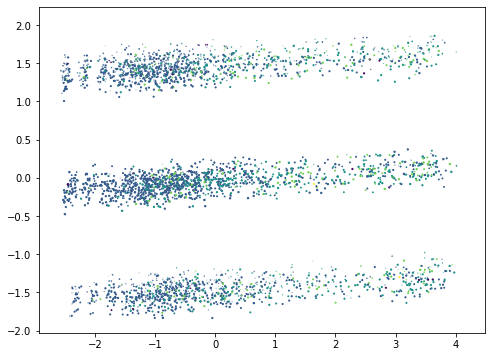

In [47]:
plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],x_pca[:,2], c = y_e)

In [51]:
df_comp = pd.DataFrame(pca.components_,columns = x_b.columns)

<AxesSubplot:>

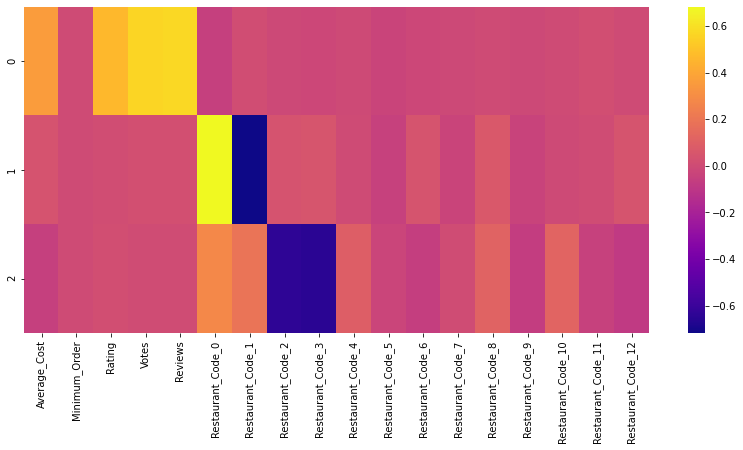

In [56]:
plt.figure(figsize = (14,6))
sns.heatmap(df_comp, cmap = 'plasma')

### SVM

#### To test PCA transformation

In [58]:
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

seed = 123

In [59]:
#Search for best parameters

params_to_search = {'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.001,0.0001]}

grid = GridSearchCV(SVR(), params_to_search, verbose = 3, n_jobs = -1)

grid.fit(x_pca,y_e)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001]},
             verbose=3)

In [60]:
grid.best_params_

{'C': 100, 'gamma': 0.0001}

In [61]:
svr = SVR(C= 100, gamma = 0.0001)

In [ ]:
svr_model = svr.fit(x_pca,y_e)

In [62]:
#Validation

metric = 'neg_root_mean_squared_error'

kfold_dtr = cross_val_score(svr ,x_pca ,y_e ,cv = 10, n_jobs = -1,scoring = metric)

In [63]:
#Metric results

print('Support Vector Regressor RMSE:',np.absolute(kfold_dtr.mean()))

Support Vector Regressor RMSE: 10.83208347155266
